In [20]:
# Pytorch Module Import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dataprocess

# Auxiliary Module Import
import json
import time
import sys
import h5py
import matplotlib.pyplot as plt

In [21]:
# GPU Check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.cuda.set_device(0)

Using device: cuda


In [22]:
# Load MATLAB v7.3 File
mat_file = h5py.File('(UT)_dataset/Homogeneous_v_position_4096000.mat', 'r')

# Dataset Check
keys = list(mat_file.keys())
for key in keys:
    dataset = mat_file[key]
    print(f"Parameter name: {key}, Size: {dataset.shape}")

Parameter name: Angle, Size: (4, 4096000)
Parameter name: coordinate, Size: (12288000, 3)
Parameter name: position, Size: (4096000, 3)


In [23]:
# Create Input and Output Tensor
angle_ = torch.tensor(mat_file['Angle'][:], dtype=torch.float32).to(device)
position = torch.tensor(mat_file['position'][:], dtype=torch.float32).to(device)
coordinate = torch.tensor(mat_file['coordinate'][:], dtype=torch.float32).to(device)
angle = angle_.transpose(0,1)
print(f"The angle dataset size: {angle.size()}")
print(f"The position dataset size: {position.size()}")
print(f"The coordinate dataset size: {coordinate.size()}")

The angle dataset size: torch.Size([4096000, 4])
The position dataset size: torch.Size([4096000, 3])
The coordinate dataset size: torch.Size([12288000, 3])


In [24]:
# Parameter Initialization
batch_size = 512  # the batch size can be changed from 1 to 4096

# Dataset Initialzation
coordinate_flat = coordinate.view(position.size(0),-1)
print(coordinate_flat.size())
input_data = torch.cat([coordinate_flat, position, torch.ones(position.size(0), 1, device=device)], dim=1)
output_data = angle
dataset = dataprocess.TensorDataset(input_data, output_data)
dataloader = dataprocess.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset Size: {len(dataset)}")
for batch_homogeneous, batch_angle in dataloader:
    print("Batch Position Size:", batch_homogeneous.size())
    print("Batch Angle Size:", batch_angle.size())
    break

torch.Size([4096000, 9])
Dataset Size: 4096000
Batch Position Size: torch.Size([512, 13])
Batch Angle Size: torch.Size([512, 4])


# The activation function
There are multiple activation functions to use in the ANN. The most commonly used is the ReLU (Rectified Linear Unit), which is quit simple. However, this activation function may have some issues in certain points. In hence, we need to use other activation funtion like Leaky ReLU `torch.nn.LeakyReLU` and GELU `torch.nn.functional.gelu`.

# Test

Epoch [1/300], Loss: 5283.3040, Learning Rate: 0.015000
Epoch [2/300], Loss: 5191.9024, Learning Rate: 0.015000
Epoch [3/300], Loss: 5172.9827, Learning Rate: 0.015000
Epoch [4/300], Loss: 5226.8213, Learning Rate: 0.015000
Epoch [5/300], Loss: 5269.3546, Learning Rate: 0.015000
Epoch [6/300], Loss: 5197.1822, Learning Rate: 0.015000
Epoch [7/300], Loss: 5212.4719, Learning Rate: 0.015000
Epoch [8/300], Loss: 5186.6329, Learning Rate: 0.015000
Epoch [9/300], Loss: 5260.3224, Learning Rate: 0.015000
Epoch [10/300], Loss: 5307.7069, Learning Rate: 0.013500
Epoch [11/300], Loss: 5289.8941, Learning Rate: 0.013500
Epoch [12/300], Loss: 5320.5460, Learning Rate: 0.013500
Epoch [13/300], Loss: 5246.9571, Learning Rate: 0.013500
Epoch [14/300], Loss: 5193.0891, Learning Rate: 0.013500
Epoch [15/300], Loss: 5255.6617, Learning Rate: 0.013500
Epoch [16/300], Loss: 5174.4169, Learning Rate: 0.013500
Epoch [17/300], Loss: 5164.3091, Learning Rate: 0.013500
Epoch [18/300], Loss: 6785.9874, Learnin

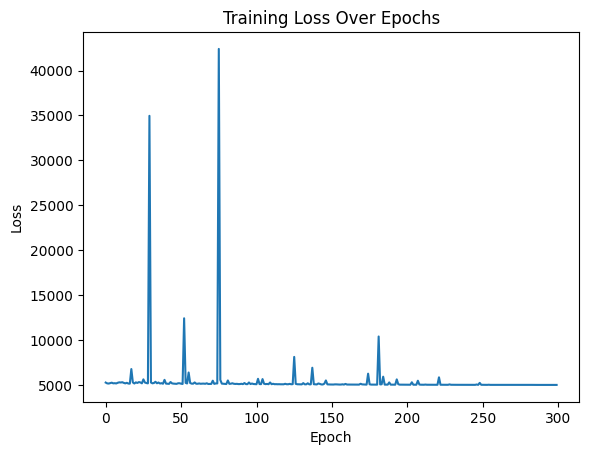

In [26]:
# ANN Model Construction
class CustomANN(nn.Module):
    def __init__(self, n):
        super(CustomANN, self).__init__()
        self.fc1 = nn.Linear(13, n)  # input layer to hidden layer
        self.fc2 = nn.Linear(n, n, bias=True)  # hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(n, n, bias=True)  # hidden layer 2 to hidden layer 3
        self.fc4 = nn.Linear(n, n, bias=True)  # hidden layer 3 to hidden layer 4
        self.fc5 = nn.Linear(n, 4)  # hidden layer 4 to output layer
        # self.activation = nn.PReLU() # use PReLU as activation function
        self.activation = nn.LeakyReLU() # use LeakyReLU as activation function

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        return x

# Model Initialization
epochs = 300 # the number of training epochs is 200
step_size = 10 # change the learning rate every 10 epochs
gamma = 0.9 # learning rate schedule ratio
lr = 0.015 # initial learning rate

model = CustomANN(24) # create an instance
model.to(device) # deploy model to cuda
criterion = nn.MSELoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr = lr) # define optimizer

# Learning Rate Schedule
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma) # step down


# Initialize an empty list to store the losses
losses = []

# Model Training
for epoch in range(epochs):
    interation_losses = []  # losses for the current epoch
    for batch_homogeneous, batch_angle in dataloader:
        # Forward Propagation
        outputs = model(batch_homogeneous)
        loss = criterion(outputs, batch_angle)

        # Backward Propagation and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        interation_losses.append(loss.item())

    # Calculate the average loss for the epoch
    epoch_loss = sum(interation_losses) / len(interation_losses)
    losses.append(epoch_loss)  # append the average loss to the list
        
    # Learning Rate Scheduler 
    scheduler.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

# Plot the loss
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Model Saving
torch.save(model.state_dict(), 'model/custom_test_13_ann_model.pth')


In [ ]:
model = CustomANN(24).to(device)
model_path = 'model/custom_test_ann_model.pth'
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
# Set the Model in Evaluation Mode
model.eval()

# Test1: the result for this test should be [90, 90, -90, -90]
test1 = torch.tensor(
    [0, 0, 1, 1, 0, 0, 0, 1, 0, 196.9859317102744, 298.4788975654116, 292.4788975654116, 1], 
    dtype=torch.float32).to(device)  
test2 = torch.tensor(
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 624, 1],
    dtype=torch.float32).to(device)

# Perform Inference
with torch.no_grad():
    output1 = model(test1)
    output2 = model(test2)

# Print the Test Result
print(f"Desired Output: [ 90  90 -90 -90]; \nModel Output: {output1.tolist()}\n\n")
print(f"Desired Output: [  0   0   0   0]; \nModel Output: {output2.tolist()}")


Desired Output: [ 90  90 -90 -90]; 
Model Output: [52.1508903503418, 109.83184814453125, 23.88813018798828, 17.168848037719727]


Desired Output: [  0   0   0   0]; 
Model Output: [4.745242595672607, 9.242289543151855, 1.8177515268325806, -3.23370361328125]
